# Designing quantum algorithms with second order functions: a flexible QPE

## 1. Introduction

Quantum Phase Estimation (QPE) is one of the fundamental quantum functions, being at the core of Shor's, HHL, and amplitude estimation algorithms. QPE is a second order function, getting a quantum function $U$ and returning an estimation of its eigenvalues (recall that any quantum function represents a unitary matrix). A QPE which encodes the eigenvalues on $m$ qubits involves a series of $m$ controlled operations of $U^{2^k}$ with $0\leq k < m-1$. Thus, acheiving a quantum advatage based on the QPE function relies on the ability to implement effeciently the power of a given unitary $U$, since otherwise, naively $U$ is called $\sum^{m-1}_{k=0} 2^k=2^m$ times &ndash; a number 
which is exponential in the number of qubits.

**In this tutorial we show how one can leverage declarative and programmatic modeling for exploring the QPE function, in the context of Hamiltonian simulation.**

We start with some basic imports

In [1]:
import sympy

from classiq import QArray, QBit, QCallable, QFunc, QParam

## 2. Defining a flexible QPE

As a first step, we define a flexible QPE function: instead of getting a single operand $U$, it gets a parametric operand, $U(p)$, where $p$ is an integer such that $U(p)\equiv U^p$. That is, the power logic of $U$ is passed explicitly with the function. In addition, the QPE itself has an integer parameter for for the phase register size.

<center>
<img src="https://classiq-docs-images.s3.amazonaws.com/qpe_flexible.png" style="width:95%">
<figcaption align = "middle"> A Flexible QPE, a rolled-up (left) and a rolled-down (right) layouts. </figcaption>
</center>

In [2]:
from classiq import H, apply_to_all, control, invert, join, qft, repeat, split


@QFunc
def qpe_flexible(
    unitary: QCallable[QParam[int], QArray[QBit]],
    state: QArray[QBit],
    phase: QArray[QBit],
) -> None:
    apply_to_all(H, phase)

    repeat(
        count=phase.len(),
        iteration=lambda index: control(
            operand=lambda: unitary(2**index, state),
            ctrl=phase[index],
        ),
    )

    invert(
        lambda: qft(phase),
    )

## 3. An example: a QPE for finding the eigenvalues of an Hermitian matrix

One of the QPE usages is to find the eigenvalues of a given Hermitian matrix $H$. Two canonical use-cases are: (A) the HHL algorithm for solving linear equations $H\cdot \vec{x}=\vec{b}$, where the matrix eigenvalues are needed to be stored on a quantum register, and (B) finding a minimal energy of a molecule Hamiltonian $H$, where one starts with preparing an initial guess for an eigenvector followed by a QPE which aims to detect the minimal eigenvalue.

In both of this use-cases, a QPE is performed on *Hamiltonian evolution* $U=e^{2\pi i H}$.

### 3.1 Hamiltonian Evolution

Hamiltonian evolution, or Hamiltonian simulation, is one of the promising usages of quantum computers, where the advantage over the classical approaches is clear and transparent (as proposed by Richard Feynman in 1982). Nevertheless, constructing a quantum program for an efficient Hamiltonian dynamics is not an easy task. The most common examples uses approximated product formulas, such as the Trotter-Suzuki (TS) formulas.

#### 3.1.1 Trotter Suzuki of order 1

We can write the Hamiltonian as a sum of Pauli strings $H=\sum_{i=0}^{L-1} a^{(k)} P^{(k)}$,
where $a^{(k)}$ are complex coefficients, and each of $P^{(k)}$ is a Pauli string of the form $s_0\otimes s_1\otimes\dots\otimes s_L$, with $s_i\in \{I, X, Y, Z\}$. Approximating Hamiltonian simulation with TS of order 1 refers to:
$$
e^{2\pi i H}\approx \left(\Pi^{L-1}_{i=0}e^{\frac{a^{(k)}}{r} P^{(k)}}\right)^r,
$$
where $r$ is called the *number of repetitions*.

* *Given a Hamiltonian, and a functional error $\epsilon$, what are the needed number of repetitions?*

Apparently, this is not an easy question. The literature provides several bounds for the number of repetitions for a given funcitonal error and error metric, however, typically, these bound are very rough, far from represnting the actual number of repetition to use. See Ref.[[1](#Errors)] for a comprehensive study.

* *When preforming a QPE the challange is even more pronounced*:


We need to preform a series of Hamiltonian simulations, with an exponentially growing evolution coefficient, $e^{2\pi i H}, \, e^{2^1 2\pi i H}, \, e^{2^2 2\pi i H}, \dots, e^{2^{m-1}2\pi i H}$. Which product formula should we use for each step, assuming we want to keep the same error per step?

In the lack of good theoretical bounds for the aforementioned questions, we can resort to some experimental exploration, with the hope of finding some theoretical clues and insights. Let see how to do this:

### 3.1.2 A flexible Trotter Suzuki for plugging into our flexible QPE

The Trotter-Suzuki of order 1 function, $\text{TS}_1$, gets an Hamiltonian $H$, evolution coefficient $t$, and repetition $r$. We are going to define a function which wraps it in the following way:

$$
\tilde{\text{TS}}_1\left(H,t,p \right) := \text{TS}_1\left(H,pt,r=f(p)\right).
$$

The function $f(p)$ tries to capture how many repetitions we need to approximate $\left(e^{2\pi i H}\right)^p=e^{p 2\pi i H}$. We will define the "goodness of approximation" in sec 3.2.


Let us define some ansatz for the repetition scaling $f(p)$:
\begin{equation}
f(p)\equiv \left\{
\begin{array}{l l}
r_0 & \text{if  } p<p_0,  \\       
r_0 \left\lceil {\left(p/p_0\right)^\gamma}\right\rceil & \text{if  } p\geq p_0
\end{array}
\right. , 
\end{equation}
where $r_0$, $p_0$ and $\gamma$ are parameters we have to tune.

In [3]:
from classiq import suzuki_trotter


def suzuki_trotter_with_power_logic(
    hamiltonian,
    pw: QParam[int],
    evolution_coefficient: QParam[float],
    order: QParam[int],
    target: QArray[QBit],
    p_0: int,
    gamma: float,
    r0: int,
) -> None:
    suzuki_trotter(
        hamiltonian,
        evolution_coefficient=evolution_coefficient * pw,
        order=1,
        repetitions=sympy.Piecewise(
            (r0, pw < p_0), (sympy.ceiling(r0 * (pw / p_0) ** gamma), True)
        ),
        qbv=target,
    )

### 3.2 QPE performance

In this tutorial, our measure for goodness of approximation refers to the functionality of the full QPE function, rather than taking some rigorous operator norm per each Hamiltonian simulations step within the QPE. We examine our approximated QPE in two ways:
1. By its ability to approximate an eigenvalue for a given eigenvector.
2. By comparing its resulting phase state with the one which results from a QPE with an exact Hamiltonian evolution, using a swap test.
  


## 4. Exploring a specific example

We consider a specific Hamiltonian, which we define with the `PauliOperator` object

In [4]:
import numpy as np

from classiq.applications.chemistry import PauliOperator

paulis = [
    ("II", 0.4),
    ("IZ", -0.05),
    ("IX", -0.03),
    ("ZZ", -0.06),
    ("XZ", 0.04),
    ("XX", -0.16),
    ("YY", -0.06),
]

po = PauliOperator(pauli_list=paulis)

We define some auxiliary functions for parsing the PauliOperator object.

In [5]:
from typing import cast

from classiq import Pauli, PauliTerm

my_list = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}


def pauli_str_to_enums(pauli):
    return [my_list[s] for s in pauli]


def pauli_operator_to_hamiltonian(pauli_operator):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_operator.pauli_list
    ]

For the demonstration, we choose one of the eigenvectors of the matrix, and test the result of the approximated QPE with respect to the expected eigenvalue.

In [6]:
a_mat = po.to_matrix().real
w, v = np.linalg.eig(a_mat)

chosen_eig = 2
print("chosen eigenvector:", v[:, chosen_eig])
print("the eigenvalue we need to estimate:", w[chosen_eig])

chosen eigenvector: [0.54233721 0.48935737 0.47765123 0.4881076 ]
the eigenvalue we need to estimate: 0.20966990092576385


***
*Note, for our specific example the most naive upper bound for TS formula of order 1 and error $\epsilon=0.1$ (defined by a spectral norm), gives $r=O(4t^2)$ [[2](#TS)], with $t=2\pi$ for the first QPE step. This corresponds to $r_0\sim 160$, and the following QPE steps grow exponentially $r_k\sim 160\times 4^k$. This will result in a huge circuit's depth. We can try to relax this by tuning the parameters of our ansatz.*

*We remark that one might consider tighter bounds, based on commutation relations[[1](#Errors)], which can give more reasobale numbers. However, the main purpose of this tutorial is to highlight the advantages of abstract, high-level modeling. Indeed, any known bound can be incorporated in the flexiable Trotter-Suzuki, by defining $f(m)$ accordingly.*
***

### 4.1. Eigenvalue estimation

We choose parameters for our power-logic function $f(p)$, construct a model, synthesize it and visualize the resulting quantum program.

In [7]:
from classiq import Output, allocate, create_model, prepare_amplitudes, synthesize

QPE_SIZE = 5
p_0 = 2 ** (QPE_SIZE - 3)
R0 = 4  # according to the naive bound this should be O(150)
GAMMA = 1.5  # according to the naive bound this should be 4


@QFunc
def main(phase_approx: Output[QArray[QBit, QPE_SIZE]]) -> None:
    state = QArray("state")
    allocate(QPE_SIZE, phase_approx)
    prepare_amplitudes(v[:, chosen_eig].tolist(), 0.0, state)
    qpe_flexible(
        unitary=lambda pw, target: suzuki_trotter_with_power_logic(
            hamiltonian=pauli_operator_to_hamiltonian(po),
            pw=pw,
            evolution_coefficient=-2 * np.pi,
            order=1,
            r0=R0,
            p_0=p_0,
            gamma=GAMMA,
            target=target,
        ),
        state=state,
        phase=phase_approx,
    )


quantum_program = synthesize(create_model(main))

In [8]:
from classiq import show

show(quantum_program)

Opening: https://platform.classiq.io/circuit/edadc669-dc8c-457c-9182-224a7f84b97d?version=0.34.0.dev0%2B124706fb0e


We execute the quantum program and examine the results: 

In [9]:
from classiq import execute

result = execute(quantum_program).result()

In [10]:
parsed_counts = result[0].value.parsed_counts
phase_counts = {
    sampled_state.state["phase_approx"] / (2**QPE_SIZE): sampled_state.shots
    for sampled_state in parsed_counts
}

exact eigenvalue: 0.20966990092576385
approximated eigenvalue: 0.21875


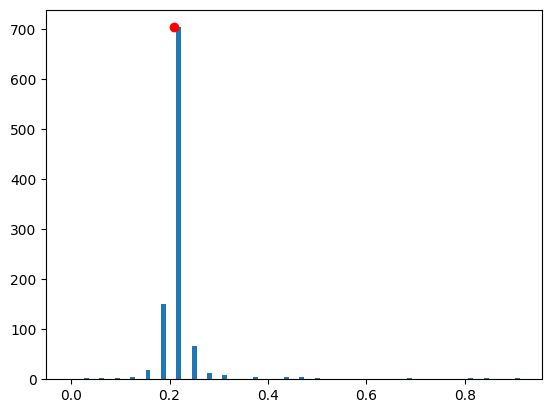

In [11]:
import matplotlib.pyplot as plt

plt.bar(phase_counts.keys(), phase_counts.values(), width=0.01)
most_probable_phase = max(phase_counts, key=phase_counts.get)
plt.plot(w[chosen_eig], phase_counts[most_probable_phase], "or")
print("exact eigenvalue:", w[chosen_eig])
print("approximated eigenvalue:", most_probable_phase)

Indeed, our approximated Hamiltonian simulations seems to be sufficient to find the eigenvalue.

### 4.2. QPE state with an exact Hamiltonian simulation vs. an approximated one

For this, we shall define two additional quantum functions: an exact Hamiltonian simulation with power-logic, and a swap test. 

In [12]:
from classiq import SWAP


@QFunc
def swap_test(psi1: QArray[QBit], psi2: QArray[QBit], test: Output[QBit]) -> None:
    def swap_all(psi_all: QArray[QBit]) -> None:
        repeat(
            count=psi1.len(),
            iteration=lambda index: SWAP(psi_all[index], psi_all[psi1.len() + index]),
        )

    psi_all = QArray("psi_all")
    allocate(1, test)
    H(test)
    join(psi1, psi2, psi_all)
    control(operand=lambda: swap_all(psi_all=psi_all), ctrl=test)
    split(psi1.len(), psi2.len(), psi_all, psi1, psi2)
    H(test)

In [13]:
from typing import List

from classiq import power, unitary


@QFunc
def unitary_with_power_logic(
    pw: QParam[int], matrix: QParam[List[List[float]]], target: QArray[QBit]
) -> None:
    power(pw, lambda: unitary(elements=matrix, target=target))

We continue with the same parameters of above for $f(p)$. We construct a model which calls two QPEs in parallel, one with an approximated Hamiltonian simulation and the other with an exact one. Finally, we perform a swap test between the resulting phases. We synthesize the model and visualize the resulting quantum program.

In [14]:
import scipy


@QFunc
def main(test: Output[QBit]) -> None:
    state = QArray("state")
    phase_approx = QArray("phase_approx")
    phase_exact = QArray("phase_exact")
    allocate(QPE_SIZE, phase_approx)
    allocate(QPE_SIZE, phase_exact)
    prepare_amplitudes(v[:, chosen_eig].tolist(), 0.0, state)
    qpe_flexible(
        unitary=lambda pw, target: suzuki_trotter_with_power_logic(
            hamiltonian=pauli_operator_to_hamiltonian(po),
            pw=pw,
            evolution_coefficient=-2 * np.pi,
            order=1,
            r0=R0,
            p_0=p_0,
            gamma=GAMMA,
            target=target,
        ),
        state=state,
        phase=phase_approx,
    )
    qpe_flexible(
        unitary=lambda arg0, arg1: unitary_with_power_logic(
            matrix=scipy.linalg.expm(2 * np.pi * 1j * po.to_matrix()).tolist(),
            pw=arg0,
            target=arg1,
        ),
        state=state,
        phase=phase_exact,
    )

    swap_test(psi1=phase_exact, psi2=phase_approx, test=test)


quantum_program = synthesize(create_model(main))

In [15]:
show(quantum_program)

Opening: https://platform.classiq.io/circuit/68ac5e9c-4b8f-4e50-8cc8-3f0582f6d22e?version=0.34.0.dev0%2B124706fb0e


Finally, we can execute and examine the results.

In [16]:
result = execute(quantum_program).result()

In [17]:
test_counts = result[0].value.counts

The overlap between the two input states of the swap test, $\psi_1$, $\psi_2$, is given by
$$
Prob(\text{test qubit at state } |0\rangle) = \frac{1}{2}\left(
1+\left|\langle \psi_1 |\psi_2\rangle\right|^2\right)
$$

In [18]:
print("Fidelity (overlap):", 2 * test_counts["0"] / sum(test_counts.values()) - 1)

Fidelity (overlap): 0.954


The results seem rather good. One can try to reduce the parameters $r_0$ and/or $\gamma$, and study experimentally the relation between the functional error and circuit's depth.

## 5. Comments

* In this tutorial we focused on Trotter Suzuki formula of order 1 for approximating the Hamiltonian simulation. One can test other implementations, including their "power-logic", such as higher order TS formulas, qDRIFT, or a combination of those.

## References

<a name='Errors'>[1]</a>: [Childs, Andrew M., et al. Theory of trotter error with commutator scaling. PRX 11 (2021): 011020.](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.011020)

<a name='TS'>[2]</a>: [Childs, Andrew M., et al. Toward the first quantum simulation with quantum speedup. PNAS 115 9456 (2018).](https://www.pnas.org/doi/abs/10.1073/pnas.1801723115)
